## Importing libraries

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

ls D:\dataset_resized

 ## Setting paths

In [4]:
base_dir="D:/dataset_resized"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Verify structure
import os
for folder in [train_dir, val_dir, test_dir]:
    print(folder, "exists:", os.path.exists(folder))

D:/dataset_resized\train exists: True
D:/dataset_resized\validation exists: True
D:/dataset_resized\test exists: True


## Data Preprocessing & Augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 34673 images belonging to 2 classes.
Found 13318 images belonging to 2 classes.
Found 11997 images belonging to 2 classes.


## Transfer Learning Using MobileNetV2

In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

## Model training

In [ ]:
checkpoint = ModelCheckpoint("mobilenetv2_deepfake.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)

print("Training complete. Model saved as mobilenetv2_deepfake.h5")

## Load the model

In [6]:
from tensorflow.keras.models import load_model
model = load_model("mobilenetv2_deepfake.h5")


## testing the data

In [7]:
test_loss, test_acc = model.evaluate(test_data)
print(f"🎯 Test Accuracy: {test_acc*100:.2f}%")


D:\dataset_resized\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 93s 240ms/step - accuracy: 0.8390 - loss: 0.3581
🎯 Test Accuracy: 83.90%


## COnfusion matrix

375/375 ━━━━━━━━━━━━━━━━━━━━ 92s 240ms/step


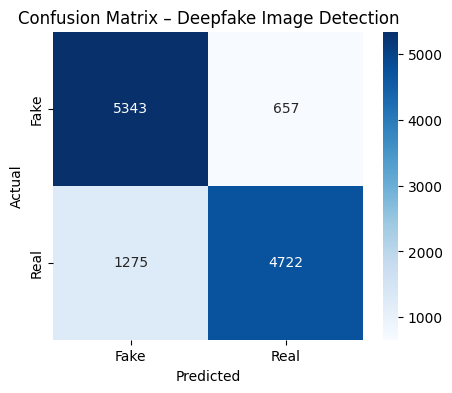

Classification Report:
              precision    recall  f1-score   support

        Fake       0.81      0.89      0.85      6000
        Real       0.88      0.79      0.83      5997

    accuracy                           0.84     11997
   macro avg       0.84      0.84      0.84     11997
weighted avg       0.84      0.84      0.84     11997



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
predictions = (model.predict(test_data) > 0.5).astype("int32")
true_labels = test_data.classes

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fake", "Real"],
            yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Deepfake Image Detection")
plt.show()

print()

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["Fake", "Real"]))


## Display Sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


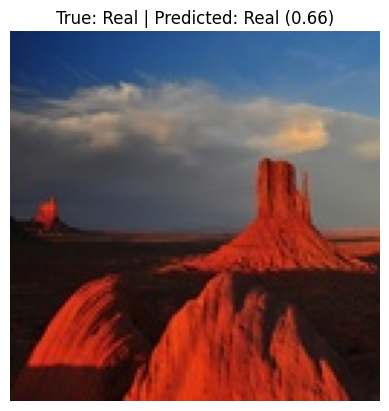

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


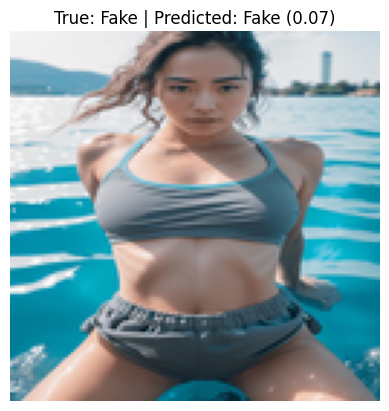

In [9]:
import random
from tensorflow.keras.preprocessing import image
import numpy as np


real_dir = f"{test_dir}/real"
fake_dir = f"{test_dir}/fake"

sample_real = random.choice(os.listdir(real_dir))
sample_fake = random.choice(os.listdir(fake_dir))

for label, path in [("Real", os.path.join(real_dir, sample_real)),
                    ("Fake", os.path.join(fake_dir, sample_fake))]:
    img = image.load_img(path, target_size=(128,128))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    predicted_label = "Real" if prediction > 0.5 else "Fake"

    plt.imshow(image.load_img(path))
    plt.title(f"True: {label} | Predicted: {predicted_label} ({prediction:.2f})")
    plt.axis("off")
    plt.show()


In [10]:
with open("evaluation_results.txt", "w") as f:
    f.write(f"Test Accuracy: {test_acc*100:.2f}%\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(classification_report(true_labels, predictions, target_names=["Fake", "Real"]))
